In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import pickle
import torch
from torch import nn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
print(torch.__version__)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

2.3.0+cu121
Using cpu device


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


__Getting data__

In [ ]:
stock = "RR.L.csv"
train = pd.read_csv("/content/drive/MyDrive/MasterProject/data/train/" + stock).set_index("Date")
validation = pd.read_csv("/content/drive/MyDrive/MasterProject/data/validation/" + stock).set_index("Date")
test = pd.read_csv("/content/drive/MyDrive/MasterProject/data/test/" + stock).set_index("Date")
test = pd.concat([validation, test], axis = 0)
train

,Open,High,Low,Close,Adj Close,Volume,Change[%]
Date,,,,,,,
2012-01-03,0.548936,0.549805,0.547816,0.544075,0.464206,0.032030,0.308960
2012-01-04,0.554043,0.551489,0.550373,0.538156,0.459025,0.029692,0.294358
2012-01-05,0.543404,0.544753,0.549947,0.541538,0.461985,0.046308,0.317382
2012-01-06,0.546809,0.546016,0.554209,0.542806,0.463095,0.042678,0.312101
2012-01-09,0.548085,0.547279,0.555487,0.543652,0.463836,0.020215,0.311050
...,...,...,...,...,...,...,...
2021-11-19,0.255786,0.254034,0.243195,0.239064,0.239064,0.267598,0.247795
2021-11-22,0.241055,0.246870,0.247606,0.238621,0.238621,0.094194,0.306870
2021-11-23,0.237236,0.244024,0.247457,0.238719,0.238719,0.059685,0.309425


__Date Embedding and cyclical transformation__

In [ ]:

def getDateRange(start_date, end_date):
    current_date = start_date
    dates = []
    while current_date <= end_date:
        dates.append(current_date.strftime('%Y-%m-%d'))
        current_date += timedelta(days=1)
    return dates

# Define the date range
start_date = datetime(2024, 5, 24) - timedelta(days=40*365)  # 40 years ago
end_date = datetime(2024, 5, 24) + timedelta(days=40*365)    # 40 years in the future

# Generate the list of dates
dictionary = getDateRange(start_date, end_date)
date_to_index = {date: index for index, date in enumerate(dictionary)}

class DateEmbeddingModel(nn.Module):
    def __init__(self, num_embeddings = 29201, embedding_dim = 8):
        super(DateEmbeddingModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)

    def forward(self, dates):
        date_indices = torch.tensor([date_to_index[date] for date in dates], dtype=torch.long)
        embedded_dates = self.embedding(date_indices)
        return embedded_dates

In [ ]:
def dateCyclicalTransformation(date):
    date = pd.to_datetime(date)

    monthSin = np.sin(2 * np.pi * date.month/12.0)
    monthCos = np.cos(2 * np.pi * date.month/12.0)
    daySin = np.sin(2 * np.pi * date.day/31.0)
    dayCos = np.cos(2 * np.pi * date.day/31.0)

    return [monthSin, monthCos, daySin, dayCos]

__Creating data loader__

In [40]:
def createSequence(dataX, dataY, lengthX, predictionHorizont):
    xData = []
    yData = []
    for i in range(len(dataX) - lengthX - predictionHorizont):
        xData.append(dataX[i:i+lengthX].values)
        yData.append(dataY[(lengthX + i):(lengthX + predictionHorizont + i)].values)
    return xData, yData

features = len(train.iloc[0])
samplesForPrediction = 10
samplesPredicted = 1
xTrain, yTrain = createSequence(train, train["Close"], samplesForPrediction, samplesPredicted)
trainDates = train.index[samplesForPrediction+1:]
xValid, yValid = createSequence(validation, validation["Close"], samplesForPrediction, samplesPredicted)
testDates = test.index[samplesForPrediction+1:]
xTest, yTest = createSequence(test, test["Close"], samplesForPrediction, samplesPredicted)

In [41]:
xTrain = torch.Tensor(xTrain).to(device)
yTrain = torch.Tensor(yTrain).to(device)
xValid = torch.Tensor(xValid).to(device)
yValid = torch.Tensor(yValid).to(device)
xTest = torch.Tensor(xTest).to(device)
yTest = torch.Tensor(yTest).to(device)

__Model__

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.LSTM(input_size = samplesForPrediction*features, hidden_size = 64, num_layers = 1, bidirectional = False, device = device)
        self.tanh = nn.Tanh()
        self.out = nn.Linear(64, samplesPredicted, device = device)

    def forward(self, x):
        x = self.flatten(x)
        x, _ = self.l1(x)
        x = self.tanh(x)
        out = self.out(x)
        return out

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): LSTM(70, 64)
  (tanh): Tanh()
  (out): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(xTrain, yTrain), shuffle=False, batch_size=4)

In [ ]:
def trainLoop(epochs):
    train_loss = []
    test_loss = []
    for epoch in range(epochs):
        model.train()
        for inputData, desired in loader:
            inputData = inputData.to(device)
            desired = desired.to(device)
            pred = model(inputData)
            loss = loss_fn(pred, desired)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        model.eval()
        with torch.no_grad():
            y_pred = model(xTrain.to(device))
            train_loss.append(loss_fn(y_pred, yTrain).cpu().numpy().tolist())
            y_pred = model(xTest.to(device))
            test_loss.append(loss_fn(y_pred, yTest).cpu().numpy().tolist())
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss[-1:]}, Test Loss: {test_loss[-1:]}')
    return train_loss, test_loss


#model = torch.load('/content/drive/MyDrive/MasterProject/lstm/model.pth')
train_loss, test_loss = trainLoop(200)
torch.save(model, 'model.pth')


Epoch [1/200], Train Loss: [0.015079588629305363], Test Loss: [0.01998324505984783]
Epoch [2/200], Train Loss: [0.007901834324002266], Test Loss: [0.011292217299342155]
Epoch [3/200], Train Loss: [0.002761638490483165], Test Loss: [0.004378898534923792]
Epoch [4/200], Train Loss: [0.008562104776501656], Test Loss: [0.005694183520972729]
Epoch [5/200], Train Loss: [0.014112093485891819], Test Loss: [0.008847194723784924]
Epoch [6/200], Train Loss: [0.01212163083255291], Test Loss: [0.008363429456949234]
Epoch [7/200], Train Loss: [0.008384410291910172], Test Loss: [0.006485763005912304]
Epoch [8/200], Train Loss: [0.00594410439953208], Test Loss: [0.005029258783906698]
Epoch [9/200], Train Loss: [0.004727011080831289], Test Loss: [0.0041852532885968685]
Epoch [10/200], Train Loss: [0.004219263792037964], Test Loss: [0.003758050501346588]
Epoch [11/200], Train Loss: [0.004066659603267908], Test Loss: [0.003561614314094186]
Epoch [12/200], Train Loss: [0.004065996501594782], Test Loss: [0

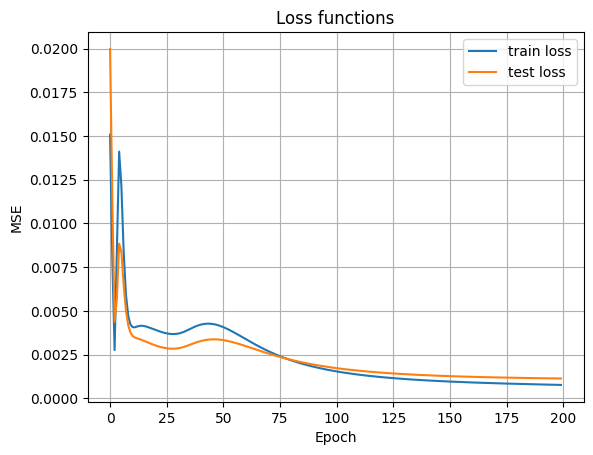

In [ ]:
fig, ax = plt.subplots()
ax.plot(train_loss)
ax.plot(test_loss)
ax.legend(["train loss", "test loss"])
ax.grid()
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.title("Loss functions")
plt.show()

__Testing__

Total Mean Squared Error: 0.0007680280832573771


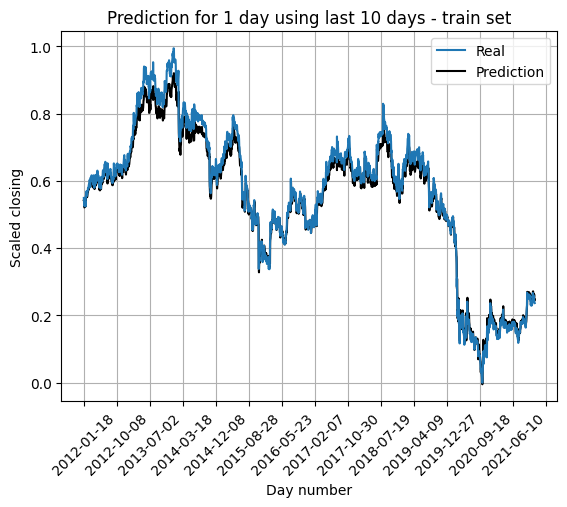

In [44]:
# Make predictions
y_pred = model(xTrain).cpu()

y_pred = y_pred.detach().numpy()


# Calculate the mean squared error across all outputs
mse_total = mean_squared_error(yTrain.cpu().detach().numpy(), y_pred)
print(f'Total Mean Squared Error: {mse_total}')

set = 5*2
real = np.concatenate(yTrain.cpu().detach().numpy()[::1])
predictions = np.concatenate(y_pred[::1])

fig, ax = plt.subplots()
ax.plot(trainDates, real, zorder = 3)
ax.plot(trainDates, predictions, color = 'black', zorder = 2)

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Optionally, set the locator to have fewer ticks
locator = plt.matplotlib.dates.AutoDateLocator(minticks=10, maxticks=20)
ax.xaxis.set_major_locator(locator)

ax.legend(["Real", "Prediction"])
#ax.axvspan(0, 4, facecolor='lightblue', alpha=0.5, zorder = 1)  # First part
#ax.axvspan(4, 9, facecolor='lightgreen', alpha=0.5, zorder = 1)  # Second part
#ax.axvspan(9, 14, facecolor='tomato', alpha=0.5, zorder = 1)  # Second third
#ax.set_ylim([0, 1])
ax.grid()
plt.ylabel("Scaled closing")
plt.xlabel("Day number")
plt.title("Prediction for 1 day using last 10 days - train set")
plt.show()



Total Mean Squared Error: 0.0011347559047862887


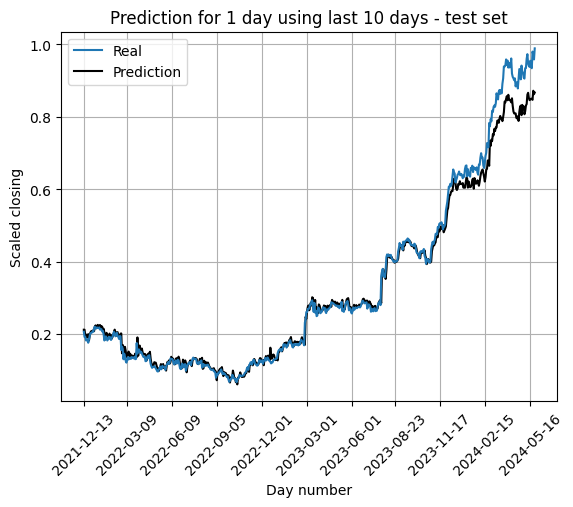

In [43]:
# Make predictions
y_pred = model(xTest).cpu()

y_pred = y_pred.detach().numpy()


# Calculate the mean squared error across all outputs
mse_total = mean_squared_error(yTest.cpu().detach().numpy(), y_pred)
print(f'Total Mean Squared Error: {mse_total}')

set = 5*2
real = np.concatenate(yTest.cpu().detach().numpy()[::1])
predictions = np.concatenate(y_pred[::1])

fig, ax = plt.subplots()
ax.plot(testDates, real, zorder = 3)
ax.plot(testDates, predictions, color = 'black', zorder = 2)

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Optionally, set the locator to have fewer ticks
locator = plt.matplotlib.dates.AutoDateLocator(minticks=10, maxticks=20)
ax.xaxis.set_major_locator(locator)

ax.legend(["Real", "Prediction"])
#ax.axvspan(0, 4, facecolor='lightblue', alpha=0.5, zorder = 1)  # First part
#ax.axvspan(4, 9, facecolor='lightgreen', alpha=0.5, zorder = 1)  # Second part
#ax.axvspan(9, 14, facecolor='tomato', alpha=0.5, zorder = 1)  # Second third
#ax.set_ylim([0, 1])
ax.grid()
plt.ylabel("Scaled closing")
plt.xlabel("Day number")
plt.title("Prediction for 1 day using last 10 days - test set")
plt.show()

